In [1]:
import importlib
import pandas as pd
import numpy as np
import math
import copy
import itertools
import inspect # Used to inspect data generator arguments
from tqdm import tqdm 
import xarray as xr
from scipy.stats import genextreme
import re
import datetime
import matplotlib.pyplot as plt # Assumed installed for example plot
from scipy.spatial.distance import cdist
from GEV import * 
from utils import *

Data Generation functions : Independant GRID

In [2]:
def create_independent_gev_grid(loc, scale, shape,
                                num_x=5, num_y=5, num_t=5):
    """
    Generates an xarray.Dataset with independent GEV samples at each point.

    Each value in the grid (x, y, t) is drawn independently from the same
    GEV(loc, scale, shape) distribution.

    Args:
        loc (float): The location parameter (mu) of the GEV distribution.
        scale (float): The scale parameter (sigma > 0) of the GEV distribution.
        shape (float): The shape parameter (xi) of the GEV distribution.
                       Note: Internally uses c = -shape for scipy.stats.genextreme.
                       shape < 0 (c > 0) => Weibull type (bounded above)
                       shape = 0 (c = 0) => Gumbel type
                       shape > 0 (c < 0) => Fréchet type (heavy tail)
        num_x (int): Number of points along the x dimension. Default is 5.
        num_y (int): Number of points along the y dimension. Default is 5.
        num_t (int): Number of points along the t dimension. Default is 5.

    Returns:
        xarray.Dataset: An xarray Dataset with dimensions ('x', 'y', 't')
                        and a single data variable 'extreme_value' containing
                        independent GEV samples.

    Raises:
        ValueError: If the scale parameter is not positive.
    """
    # --- Input Validation ---
    if scale <= 0:
        raise ValueError("Scale parameter (sigma) must be positive.")

    # --- Define Coordinates ---
    x_coords = np.arange(num_x)
    y_coords = np.arange(num_y)
    t_coords = np.arange(num_t)

    # --- Generate GEV Data ---
    total_values = num_x * num_y * num_t
    # Generate independent samples using the specified parameters
    # Note: Using c = -shape consistent with user input convention
    gev_data_flat = genextreme.rvs(c=-shape, loc=loc, scale=scale, size=total_values)
    gev_data_3d = gev_data_flat.reshape(num_x, num_y, num_t)

    # --- Create xarray DataArray ---
    data_variable = xr.DataArray(
        data=gev_data_3d,
        coords={'lon': x_coords, 'lat': y_coords, 'time': t_coords},
        dims=['lon', 'lat', 'time'],
        name='extreme_value',
        attrs={
            'description': 'Independent synthetic data generated from a GEV distribution.',
            'units': 'unitless',
            'location': loc,
            'scale': scale,
            'shape': shape, # Store the input shape parameter (xi)
        }
    )
    # --- Create xarray Dataset ---
    dataset = xr.Dataset({'extreme_value': data_variable})
    dataset.attrs['creation_timestamp'] = datetime.datetime.now().isoformat()
    dataset.attrs['source'] = 'Generated by create_independent_gev_grid'
    dataset.attrs['grid_type'] = 'dimensionless integer coordinates'
    dataset.attrs['dependencies'] = 'Identically distributed, independent samples'

    return dataset

Data Generation functions : Dependant GRID

In [4]:
# Default values dictionary (can be centralized or defined per function)
TrendFunction = Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]
def generate_complete_trend_st(
    seed: int,
    params: Dict[str, Any]
) -> Tuple[TrendFunction, Tuple[float, float, float, float]]:
    """
    Generates a complete linear trend function:
    f(x, y, t) = intercept + coeff_x * x + coeff_y * y + t_coeff * t
    using parameters provided in a dictionary.

    Samples coefficients for x, y, and temporal components, and an intercept,
    using ranges specified in the params dictionary.

    Args:
        seed (int): Seed for the random number generator.
        params (Dict[str, Any]): Dictionary containing the parameter ranges:
            - 'coeff_x_range' (Tuple[float, float]): Min/max for x coefficient.
            - 'coeff_y_range' (Tuple[float, float]): Min/max for y coefficient.
            - 'intercept_range' (Tuple[float, float]): Min/max for intercept.
            - 't_coeff_range' (Tuple[float, float]): Min/max for time coefficient.

    Returns:
        Tuple containing:
        - TrendFunction: The lambda function calculating the trend.
        - Tuple[float, float, float, float]: The generated parameters
          (intercept, coeff_x, coeff_y, t_coeff).

    Raises:
        KeyError: If any of the required range keys ('coeff_x_range',
                  'coeff_y_range', 'intercept_range', 't_coeff_range')
                  are missing from the params dictionary.
        TypeError: If the values associated with the range keys are not
                   subscriptable (e.g., None or not a tuple/list).
    """
    rng = np.random.default_rng(seed)

    # Extract parameters from dictionary. Using .get() provides a way to check
    # for missing keys explicitly for clearer error messages.
    coeff_x_range = params.get('coeff_x_range',(0, 0))
    coeff_y_range = params.get('coeff_y_range',(0, 0))
    intercept_range = params.get('intercept_range',(0, 0))
    t_coeff_range = params.get('t_coeff_range',(0, 0))

    # 1. Sample coefficients and intercept using the provided ranges
    # This assumes the ranges are valid tuples like (min, max)
    # A TypeError will occur here if the ranges are not subscriptable (e.g., None)
    coeff_x = rng.uniform(coeff_x_range[0], coeff_x_range[1])
    coeff_y = rng.uniform(coeff_y_range[0], coeff_y_range[1])
    t_coeff = rng.uniform(t_coeff_range[0], t_coeff_range[1])
    intercept = rng.uniform(intercept_range[0], intercept_range[1])

    # 2. Construct lambda function (capturing sampled values i, cx, cy, tc)
    # The lambda applies the complete linear trend formula to grid inputs
    trend_func: TrendFunction = lambda x_grid, y_grid, t_grid, i=intercept, cx=coeff_x, cy=coeff_y, tc=t_coeff: i + cx * x_grid + cy * y_grid + tc * t_grid

    # 3. Store all generated parameters
    generated_params = (intercept, coeff_x, coeff_y, t_coeff)

    # 4. Return the function and the parameters
    return trend_func, generated_params

# Example Usage (assuming you have a params dictionary defined):
# params_dict = {
#     'coeff_x_range': (-0.5, 0.5),
#     'coeff_y_range': (-0.3, 0.3),
#     'intercept_range': (10.0, 20.0),
#     't_coeff_range': (-0.05, 0.05)
# }
# trend_function, trend_params = generate_complete_trend_st(seed=42, params=params_dict)
# print(f"Generated trend parameters: {trend_params}")
# # You can then use trend_function(x_coords, y_coords, t_coords)

# --- Main GEV Data Generation Function ---
def create_gev_nonstationary(
    loc: float = 0.0,
    scale: float = 1.0,
    shape: float = 0.0,
    trend_funcs: Optional[Dict[str, Optional[TrendFunction]]] = None,
    num_x: int = 50,
    num_y: int = 50,
    num_t: int = 5,
    seed: int = 0
) -> xr.Dataset:
    """
    Generates GEV data with potentially non-stationary location, scale, and shape parameters
    varying as functions of normalized spatial coordinates (x, y) and normalized time (t).

    This version accepts user-defined functions (including lambdas) for trends.

    Coordinates:
        - x: Runs from 0 to 1 along the 'lon' dimension.
        - y: Runs from 0 to 1 along the 'lat' dimension.
        - t: Runs from 0 to 1 along the 'time' dimension. (Normalized)

    Each parameter (loc, scale, shape) is calculated as:
    param(x, y, t) = base_param + trend_function(x, y, t)
    The `trend_function` is provided directly as a callable via the `trend_funcs` dictionary.
    If the corresponding key ('loc', 'scale', 'shape') is missing or its value is None
    in `trend_funcs`, the parameter is constant (base_param).

    **Trend Function Signature:**
    Any function provided must accept three arguments:
        1. x_grid (np.ndarray): Meshgrid of x coordinates [0,1] (shape: num_x, num_y, num_t).
        2. y_grid (np.ndarray): Meshgrid of y coordinates [0,1] (shape: num_x, num_y, num_t).
        3. t_grid (np.ndarray): Meshgrid of **normalized** t coordinates [0,1] (shape: num_x, num_y, num_t).
    It must return a numpy array of the same shape (num_x, num_y, num_t) representing
    the trend component to be added to the base parameter value.

    Args:
        loc (float): Base value for the location parameter (mu). Default is 0.0.
        scale (float): Base value for the scale parameter (sigma). Must be > 0 if no
                       scale trend function is provided. Default is 1.0.
        shape (float): Base value for the shape parameter (xi). Default is 0.0.
        trend_funcs (Dict[str, Optional[TrendFunction]], optional): Dictionary mapping
            parameter names ('loc', 'scale', 'shape') to optional callable functions
            that define the trend. Defaults to None (no trends).
            Example:
            {
                # Trend increases by 0.5 over the full normalized time period
                'loc': lambda x, y, t: 0.5 * t + 0.1 * x,
                'scale': my_scale_func # where my_scale_func is defined elsewhere
            }
        num_x (int): Number of points along the x dimension ('lon'). Default is 50.
        num_y (int): Number of points along the y dimension ('lat'). Default is 50.
        num_t (int): Number of points along the t dimension ('time'). Default is 5.
        seed (int): Seed for the random number generator used for GEV sampling. Default is 0.

    Returns:
        xarray.Dataset: An xarray Dataset containing GEV samples ('extreme_value')
                        and the calculated parameters ('location', 'scale', 'shape')
                        with potentially varying parameters. Base values and representations
                        of the trend functions used are stored as attributes.

    Raises:
        ValueError: If base scale <= 0 (and no trend func), if calculated scale <= 0,
                    or if a provided trend function returns an array of incorrect shape.
        TypeError: If an object provided in `trend_funcs` is not callable or does not
                   match the required signature.
        Exception: Any exception raised by the user-provided trend functions.
    ```
    """
    # Initialize trend_funcs if None
    if trend_funcs is None:
        trend_funcs = {}

    # Extract trend functions for validation and attribute storage
    loc_trend_func = trend_funcs.get('loc', None)
    scale_trend_func = trend_funcs.get('scale', None)
    shape_trend_func = trend_funcs.get('shape', None)

    # --- Basic Input Validation ---
    if scale_trend_func is None and scale <= 0:
        raise ValueError("Base scale parameter (sigma) must be positive if scale trend function is not provided.")

    # --- Define Coordinates (Normalized x, y, t) ---
    x_coords = np.linspace(0, 1, num_x)
    y_coords = np.linspace(0, 1, num_y)
    # *** MODIFIED: Use linspace for t to normalize between 0 and 1 ***
    t_coords = np.linspace(0, 1, num_t)
    expected_shape = (num_x, num_y, num_t)

    # --- Create meshgrids for x, y, t ---
    # Use 'ij' indexing so shape matches (num_x, num_y, num_t)
    # t_grid will now contain values between 0 and 1.
    x_grid, y_grid, t_grid = np.meshgrid(x_coords, y_coords, t_coords, indexing='ij')

    # --- Helper function to calculate a single parameter using a provided function ---
    def _calculate_parameter(param_name: str, base_value: float,
                             trend_func: Optional[TrendFunction],
                             x: np.ndarray, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        """Calculates the parameter array by calling the trend function if provided."""

        if trend_func is None:
            # No trend, use constant base value
            return np.full(expected_shape, base_value, dtype=float)

        if not callable(trend_func):
            raise TypeError(f"Object provided for '{param_name}' trend is not callable (not a function or lambda).")

        try:
            # Call the user-provided function (passing normalized t_grid)
            trend_component = trend_func(x, y, t)

            # Validate the output shape
            if not isinstance(trend_component, np.ndarray) or trend_component.shape != expected_shape:
                 # Try broadcasting if scalar output is given
                 if np.isscalar(trend_component):
                     trend_component = np.full(expected_shape, trend_component, dtype=float)
                 else:
                    raise ValueError(f"Trend function for '{param_name}' returned an array with "
                                     f"shape {np.shape(trend_component)}, but expected {expected_shape}.")

        except TypeError as e:
            # Catch errors likely related to incorrect function signature
            raise TypeError(f"Error calling trend function for '{param_name}'. "
                            f"Ensure it accepts 3 arguments (x_grid, y_grid, t_grid). Original error: {e}") from e
        except Exception as e:
            # Re-raise any other exceptions from the user's function
            raise RuntimeError(f"Error executing trend function for '{param_name}'. Original error: {e}") from e

        # Add trend to the base value
        param_array = base_value + trend_component.astype(float) # Ensure float type

        return param_array

    # --- Calculate Spatially and Temporally Varying Parameters ---
    try:
        loc_xyt = _calculate_parameter('loc', loc, loc_trend_func, x_grid, y_grid, t_grid)
        scale_xyt = _calculate_parameter('scale', scale, scale_trend_func, x_grid, y_grid, t_grid)
        shape_xyt = _calculate_parameter('shape', shape, shape_trend_func, x_grid, y_grid, t_grid)
    except (ValueError, TypeError, RuntimeError) as e:
        # Re-raise calculation errors for clarity
        raise e
    except Exception as e:
        # Catch unexpected errors during calculation
        raise RuntimeError(f"An unexpected error occurred during parameter calculation: {e}") from e


    # --- Validate Calculated Scale Parameter ---
    if np.any(scale_xyt <= 0):
        min_scale = np.min(scale_xyt)
        raise ValueError(f"Calculated scale parameter must be positive everywhere, but found "
                         f"minimum value {min_scale:.4f}. Check base 'scale' ({scale}) and "
                         f"the 'scale' trend function: {scale_trend_func!r}.") # Use repr for function

    # --- Generate GEV Data ---
    # Use the calculated parameter arrays. Note: scipy.stats.genextreme uses c = -shape.
    gev_data_3d = genextreme.rvs(c=-shape_xyt, loc=loc_xyt, scale=scale_xyt,
                                 size=expected_shape)

    # --- Create xarray DataArrays for parameters and data ---
    # Use the normalized t_coords for the time dimension
    coords_dict = {'lon': x_coords, 'lat': y_coords, 'time': t_coords}
    dims_list = ['lon', 'lat', 'time']

    # Helper to get a string representation of the function for attributes
    def func_repr(func):
        if func is None:
            return 'None'
        try:
            # Use repr for better info, especially for named functions
            return repr(func)
        except Exception:
            return str(func) # Fallback

    data_var = xr.DataArray(
        data=gev_data_3d,
        coords=coords_dict,
        dims=dims_list,
        name='extreme_value',
        attrs={
            'description': 'Synthetic GEV samples.',
            'units': 'unitless'
        }
    )
    loc_var = xr.DataArray(
        data=loc_xyt, coords=coords_dict, dims=dims_list, name='location',
        attrs={'description': 'GEV location parameter (mu)', 'base_value': loc, 'trend_function': func_repr(loc_trend_func)}
    )
    scale_var = xr.DataArray(
        data=scale_xyt, coords=coords_dict, dims=dims_list, name='scale',
         attrs={'description': 'GEV scale parameter (sigma)', 'base_value': scale, 'trend_function': func_repr(scale_trend_func)}
    )
    shape_var = xr.DataArray(
        data=shape_xyt, coords=coords_dict, dims=dims_list, name='shape',
        attrs={'description': 'GEV shape parameter (xi)', 'base_value': shape, 'trend_function': func_repr(shape_trend_func)}
    )

    # --- Create xarray Dataset ---
    dataset = xr.Dataset({
        'extreme_value': data_var,
        'location': loc_var,
        'scale': scale_var,
        'shape': shape_var
        })

    dataset.attrs['creation_timestamp'] = datetime.datetime.now(datetime.timezone.utc).isoformat()
    dataset.attrs['source'] = 'Generated by create_gev_nonstationary_lambda'
    # *** MODIFIED: Update grid_type attribute ***
    dataset.attrs['grid_type'] = 'normalized spatial and temporal coordinates (0-1)'
    dataset.attrs['dependencies'] = 'Spatio-temporal dependence via user-provided functions for loc, scale, and shape.'
    # Store the input trend function dictionary representation for reference
    dataset.attrs['input_trend_funcs'] = str({k: func_repr(v) for k, v in trend_funcs.items()})

    return dataset

print("\n--- Example 2: Lambda Trends (Normalized Time) ---")
trends = {
    'loc': lambda x, y, t: 10 * t + 100*x        
}
ds_trends = create_gev_nonstationary(
    loc=10, scale=2, shape=0.1, trend_funcs=trends, num_x=30, num_y=30, num_t=100, seed=42
)



--- Example 2: Lambda Trends (Normalized Time) ---


Data visualization functions

In [5]:
def plot_time(
    data: Union[xr.Dataset, xr.DataArray],
    lon_index: int = 0,
    lat_index: int = 0,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots the time series for a specific spatial point in the xarray data.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        lon_index: The integer index for the longitude dimension.
        lat_index: The integer index for the latitude dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data" # Use DA name, fallback to arg or default
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Data Point ---
        # Select the data point using integer indices based on provided dim names
        selection_indices = {lon_dim: lon_index, lat_dim: lat_index}
        selected_point_data = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(10, 5))
        selected_point_data.plot.line(marker='.', linestyle='-') # Use xarray's plotting

        # --- Customize Plot ---
        # Attempt to get coordinate values for title, fallback if coords missing
        try:
             lon_val_str = f"{selected_point_data[lon_dim].item():.2f}"
        except:
             lon_val_str = f"index {lon_index}" # Fallback if coord missing/not scalar

        try:
             lat_val_str = f"{selected_point_data[lat_dim].item():.2f}"
        except:
             lat_val_str = f"index {lat_index}" # Fallback

        plt.title(f"Time Series for '{actual_var_name}'\nat {lon_dim}={lon_val_str}, {lat_dim}={lat_val_str}")
        plt.xlabel(f"Time ({time_dim})")
        plt.ylabel(actual_var_name)
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Indices {lon_dim}={lon_index}, {lat_dim}={lat_index} are out of bounds "
              f"for data with shape {da.shape}. Check dimensions: {da.dims}.")
    except Exception as e:
        print(f"An error occurred during time series plotting: {e}")


def plot_map(
    data: Union[xr.Dataset, xr.DataArray],
    t_index: int = 0,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots a 2D spatial map (image) of the data at a specific time index 't'.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        t_index: The integer index for the time dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data"
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Time Slice ---
        selection_indices = {time_dim: t_index}
        selected_time_slice = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(8, 7)) # Adjusted size slightly
        # Ensure plot uses correct x,y dimensions based on args
        selected_time_slice.plot.imshow(
            x=lon_dim, y=lat_dim, cmap='viridis', robust=True # robust handles outliers in color scale
        )

        # --- Customize Plot ---
        # Attempt to get time coordinate value for title
        try:
             time_val_str = f"{selected_time_slice[time_dim].item()}"
             # Try formatting nicely if it's datetime-like
             if np.issubdtype(selected_time_slice[time_dim].dtype, np.datetime64):
                  # Convert numpy datetime64 to something more readable if possible
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item()) # Round to nearest second
                  except: pass # Keep original if conversion fails
             elif np.issubdtype(selected_time_slice[time_dim].dtype, np.timedelta64):
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item())
                  except: pass
        except:
             time_val_str = f"index {t_index}" # Fallback

        plt.title(f"Spatial Map for '{actual_var_name}'\nat {time_dim} = {time_val_str}")
        # Labels are usually handled well by xarray based on coordinates
        # plt.xlabel(f"{lon_dim}") # Usually set automatically
        # plt.ylabel(f"{lat_dim}") # Usually set automatically
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Time index {time_dim}={t_index} is out of bounds "
              f"for data with time dimension size {da.dims[time_dim]}.")
    except Exception as e:
        print(f"An error occurred during spatial map plotting: {e}")


Data Generation

Fitting

In [6]:
def reconstruct_xarray_from_flat(
    prediction_params_flat: np.ndarray, 
    mdt: Dict[str, Any],
    original_ds: xr.Dataset
) -> xr.Dataset:
    """
    Reconstructs an xarray Dataset with GEV parameters (loc, scale, shape)
    from a flattened prediction array (parameters, time, space).

    Assumes the input array corresponds to loc, scale, shape in order along
    the first dimension.
    Reverses the flattening performed by xarray_to_endog_exog
    (which uses stack(space=('lat', 'lon'))).

    Args:
        prediction_params_flat: The 3D NumPy array prediction with shape
                                (3, T, S) for [loc, scale, shape], where
                                S = N_lat * N_lon.
        mdt: Metadata dictionary containing 't', 'n_lat', 'n_lon', 's'.
        original_ds: The original xarray Dataset from which the data was
                     flattened. Used to retrieve coordinates and ensure consistency.

    Returns:
        An xarray Dataset containing three data variables ('prediction_loc',
        'prediction_scale', 'prediction_shape'), each with dimensions
        ('lon', 'lat', 'time').

    Raises:
        ValueError: If shapes or metadata are inconsistent.
        TypeError: If prediction_params_flat is not a NumPy array.
    """
    # 1. Extract Dimensions from metadata
    try:
        T = mdt['t']
        N_lat = mdt['n_lat']
        N_lon = mdt['n_lon']
        S = mdt['s'] # Total spatial points
    except KeyError as e:
        raise ValueError(f"Metadata dictionary 'mdt' is missing required key: {e}")

    # --- Simplified Input Validation ---
    if not isinstance(prediction_params_flat, np.ndarray):
        raise TypeError("prediction_params_flat must be a NumPy array.")

    expected_shape_3d = (3, T, S)
    if prediction_params_flat.shape != expected_shape_3d:
            # Check if S in metadata was inconsistent but dims otherwise match
            if prediction_params_flat.shape[0] == 3 and \
               prediction_params_flat.shape[1] == T and \
               prediction_params_flat.shape[2] == N_lat * N_lon:
                 warnings.warn(f"Metadata inconsistency: mdt['s'] ({S}) != N_lat ({N_lat}) * N_lon ({N_lon}). "
                               f"Input array shape ({prediction_params_flat.shape}) matches (3, T, N_lat*N_lon). "
                               f"Proceeding by correcting S.", UserWarning)
                 S = N_lat * N_lon # Correct S based on dims
            else:
                 # Shape mismatch is real
                 raise ValueError(f"Input NumPy array prediction_params_flat has incorrect shape {prediction_params_flat.shape}. "
                                  f"Expected {expected_shape_3d} based on metadata (parameters, time, space).")
    # --- End Input Validation ---


    # 3. Get Coordinates from original dataset
    try:
        lon_coord_name = 'lon'
        lat_coord_name = 'lat'
        time_coord_name = 'time'

        lon_coords = original_ds[lon_coord_name]
        lat_coords = original_ds[lat_coord_name]
        time_coords = original_ds[time_coord_name]

        # Verify coordinate lengths match metadata dimensions
        if len(lon_coords) != N_lon:
            raise ValueError(f"Original dataset '{lon_coord_name}' coord length ({len(lon_coords)}) "
                             f"doesn't match metadata n_lon ({N_lon})")
        if len(lat_coords) != N_lat:
            raise ValueError(f"Original dataset '{lat_coord_name}' coord length ({len(lat_coords)}) "
                             f"doesn't match metadata n_lat ({N_lat})")
        if len(time_coords) != T:
             if len(time_coords) < T :
                  raise ValueError(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is less than metadata T ({T})")
             elif len(time_coords) > T:
                  warnings.warn(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is greater than metadata T ({T}). Using the first {T} time coordinates.", UserWarning)
                  time_coords = time_coords[:T]

    except KeyError as e:
        raise ValueError(f"Original dataset 'original_ds' is missing expected coordinate: {e}")

    # --- Reconstruct each parameter ---
    reconstructed_params = {}
    param_names = ['location', 'scale', 'shape']

    for i, param_name in enumerate(param_names):
        # Extract the flattened data for this parameter: shape (T, S)
        param_flat = prediction_params_flat[i, :, :]

        # 4. Transpose and Reshape
        # Input shape (T, S) -> Transpose to (S, T)
        # Reshape S (where lon varied fastest) back to (N_lat, N_lon)
        # Resulting shape before final transpose: (N_lat, N_lon, T)
        try:
            reshaped_data_lat_lon_time = param_flat.T.reshape((N_lat, N_lon, T))
        except ValueError as e:
            raise ValueError(f"Reshaping failed for parameter '{param_name}' (to N_lat, N_lon, T). "
                             f"Check consistency. Original error: {e}")

        # 5. Create intermediate DataArray with (lat, lon, time) order
        param_da_intermediate = xr.DataArray(
            data=reshaped_data_lat_lon_time,
            coords=[lat_coords, lon_coords, time_coords],
            dims=[lat_coord_name, lon_coord_name, time_coord_name],
            name=param_name
        )

        # 6. Transpose to final desired order ('lon', 'lat', 'time')
        param_da_final = param_da_intermediate.transpose(lon_coord_name, lat_coord_name, time_coord_name)

        reconstructed_params[param_name] = param_da_final

    # 7. Create final Dataset
    reconstructed_ds = xr.Dataset(reconstructed_params)

    return reconstructed_ds

Bias, Variance, MSE

In [ ]:
def calculate_parameter_metrics(
    fit_ds: xr.Dataset,
    ground_truth_ds: xr.Dataset,
    param_mapping: Dict[str, Dict[str, str]] = {
        'location': {'fit': 'prediction_loc', 'true': 'location'},
        'scale': {'fit': 'prediction_scale', 'true': 'scale'},
        'shape': {'fit': 'prediction_shape', 'true': 'shape'}
    }
) -> Dict[str, Dict[str, float]]:
    """
    Calculates Bias, Variance (of the estimate), and MSE for fitted GEV
    parameters compared against true parameters.

    MSE is calculated using the formula: MSE = Bias² + Variance(Estimate).

    Args:
        fit_ds: Dataset containing the fitted parameters (e.g., 'prediction_loc').
        ground_truth_ds: Dataset containing the true parameters (e.g., 'location').
        param_mapping: Dictionary mapping canonical parameter names (keys) to
                       a dictionary containing the variable names for the 'fit'
                       and 'true' parameters in the respective datasets.

    Returns:
        A dictionary where keys are the canonical parameter names ('location',
        'scale', 'shape') and values are dictionaries containing the calculated
        scalar metrics ('bias', 'variance', 'mse') for that parameter.

    Raises:
        ValueError: If required variables are missing, datasets are incompatible,
                    or alignment/filtering results in no valid data points.
        KeyError: If parameter names or 'fit'/'true' keys in mapping are invalid.
    """
    results = {}
    # Define a small epsilon for checks if needed, though not used in this version
    # EPSILON = 1e-9

    for param_name, mapping in param_mapping.items():
        # --- Check mapping and variables exist ---
        if 'fit' not in mapping or 'true' not in mapping:
             raise KeyError(f"Mapping for '{param_name}' must contain 'fit' and 'true' keys.")
        fit_var_name = mapping['fit']
        true_var_name = mapping['true']

        if fit_var_name not in fit_ds:
            raise KeyError(f"Fitted variable '{fit_var_name}' (for {param_name}) not found in fit_ds.")
        if true_var_name not in ground_truth_ds:
            raise KeyError(f"True variable '{true_var_name}' (for {param_name}) not found in ground_truth_ds.")

        fit_da = fit_ds[fit_var_name]
        true_da = ground_truth_ds[true_var_name]

        # --- Align Data and Handle NaNs ---
        try:
            fit_aligned, true_aligned = xr.align(fit_da, true_da, join="inner")

            # Ensure float type
            fit_aligned = fit_aligned.astype(float)
            true_aligned = true_aligned.astype(float)

            # Create a mask for valid, non-NaN pairs
            valid_mask = np.isfinite(fit_aligned) & np.isfinite(true_aligned)
            if not valid_mask.any():
                raise ValueError(f"Alignment/filtering resulted in zero valid overlapping points for parameter '{param_name}'. Check coordinates and NaNs.")

            # Apply mask for calculations - use .where to keep original shape but mask invalid points
            fit_masked = fit_aligned.where(valid_mask)
            true_masked = true_aligned.where(valid_mask)
            error_masked = fit_masked - true_masked # Error calculated only on valid points

        except Exception as e:
            raise ValueError(f"Failed to align or process parameters '{fit_var_name}' and '{true_var_name}'. Check dimensions and coordinates. Original error: {e}")

        # --- Calculate Metrics (operating on masked data) ---
        # Use skipna=True which is default for xarray ops like mean/var on masked arrays
        bias = float(error_masked.mean(skipna=True).item())

        # Calculate Variance of the *Estimate* (fitted parameter)
        # Use the masked fitted values
        variance = float(error_masked.var(skipna=True).item())

        # Check if calculations resulted in NaN (can happen if all values were masked)
        if np.isnan(bias) or np.isnan(variance):
              results[param_name] = {'bias': np.nan, 'variance': np.nan, 'mse': np.nan}
              warnings.warn(f"Bias or Variance calculation resulted in NaN for parameter '{param_name}'. Check input data for all NaNs after alignment.")
              continue # Skip to the next parameter

        # Calculate MSE using the Bias-Variance decomposition formula
        mse = variance + bias**2

        # --- Store Results ---
        results[param_name] = {
            'bias': bias,
            'variance': variance, # Variance of the estimate
            'sd':  np.sqrt(variance), # Variance of the estimate
            'mse': mse,
            'rmse' : np.sqrt(mse)
        }


    return results

BIG SIM 

1] Trend in X

In [ ]:
def run_simulation( # Renamed for clarity (optional)
    sim_config: Dict[str, Any],
    show_progress: bool = True,
    marginal: bool = False
) -> xr.Dataset: # <<< Changed return type annotation
    """
    Runs a flexible Monte Carlo simulation scenario and returns a stacked
    xarray Dataset containing the fitted parameters from each run.

    This function uses a configuration dictionary to set up and run the
    simulation. It generates ground truth data with potentially non-stationary
    GEV parameters, fits a GEV model (jointly or marginally), reconstructs
    the fitted parameters into an xarray Dataset for each run, and then
    concatenates these datasets along a new 'simulation_run' dimension.

    Args:
        sim_config (Dict[str, Any]): Dictionary containing ALL parameters needed:
            - 'trend_config': (Dict[str, Dict]) Nested dictionary structuring
                              trend generation for 'location', 'scale', 'shape'.
                              Each sub-dict contains:
                                - 'generator_func': Callable generator function or None.
                                - 'params': Dict of parameters for the generator func.
            - 'base_location', 'base_scale', 'base_shape': Base GEV values.
            - 'res', 'num_t': Data dimensions (res implies sqrt(num_s)).
            - 'num_simulations': Number of runs.
            - 'gev_params_order': Order of GEV params (e.g., ['location', 'scale', 'shape']).
            - 'random_seed_base': Seed offset.
            - 'endog_var', 'include_time_coords', 'include_space_coords': Flattening.
            - 'fit_method', 'gev_param_exog_map', 'start_params',
              'apply_start_noise', 'start_params_noise_std': Fitting setup.
        show_progress (bool): If True, display a tqdm progress bar.
        marginal (bool): If False (default), fits the GEV model jointly.
                         If True, fits the GEV model marginally for each spatial location.

    Returns:
        xr.Dataset: An xarray Dataset containing the fitted parameters
                    (e.g., location, scale, shape) from all successful
                    simulation runs, stacked along a new 'simulation_run'
                    dimension. Coordinates from the original datasets
                    (like time, x, y) are preserved.

    Raises:
        KeyError: If essential parameters are missing from sim_config.
        TypeError: If generator functions are not callable.
        ValueError: If parameter values are inconsistent or marginal fitting fails.
        RuntimeError: If no simulation runs complete successfully.
    """
    # --- Extract essential parameters from config ---
    try:
        # Simulation Control
        num_simulations = sim_config['num_simulations']
        random_seed_base = sim_config.get('seed', 0)
        gev_params_order = sim_config['gev_params_order'] # Still needed for reconstruction logic potentially

        # Trend Generation Config
        trend_config = sim_config.get('trend_config', {})

        # Base GEV Params
        base_location = sim_config['base_location']
        base_scale = sim_config['base_scale']
        base_shape = sim_config['base_shape']

        # Data Creation Params
        res = sim_config['res']
        num_t = sim_config['num_t']

        # Flattening Params
        endog_var = sim_config.get('endog_var', 'extreme_value')
        include_time_coords = sim_config.get('include_time_coords', True)
        include_space_coords = sim_config.get('include_space_coords', True)

        # Fitting Params
        fit_method = sim_config['fit_method']
        start_params_config = sim_config.get('start_params', None)
        apply_start_noise = sim_config.get('apply_start_noise', False)
        start_params_noise_std = sim_config.get('start_params_noise_std', 0.1)
        gev_param_exog_map = sim_config['gev_param_exog_map']

    except KeyError as e:
        raise KeyError(f"Essential parameter '{e}' missing from sim_config dictionary.") from e

    # --- Initialize collectors ---
    fit_datasets_list = [] # <<< New: List to collect fit_ds from each run
    fit_param_list = []
    rng = np.random.default_rng()

    iterable = range(num_simulations)
    fit_type = "Marginal" if marginal else "Joint"
    desc = f"Sim ({fit_type}, res={res})"
    if show_progress:
        iterable = tqdm(iterable, desc=desc)

    # --- Simulation Loop ---
    for i in iterable:
        current_seed = random_seed_base + i
        # run_metrics_array = {metric: np.full(num_gev_params, np.nan) for metric in metrics_to_track} # <<< Removed

        try:
            # 1. Generate Trend Functions (Code unchanged)
            trend_funcs = {}
            gev_param_key_map = {'location': 'loc', 'scale': 'scale', 'shape': 'shape'}
            for j, gev_param_name in enumerate(gev_params_order):
                param_trend_config = trend_config.get(gev_param_name)
                trend_lambda = None
                if isinstance(param_trend_config, dict):
                    generator_func = param_trend_config.get('generator_func')
                    generator_params = param_trend_config.get('params', {})
                    if callable(generator_func):
                        try:
                            trend_lambda, _ = generator_func(
                                seed=current_seed + j,
                                params=generator_params
                            )
                        except Exception as gen_e:
                            warnings.warn(f"Error calling generator '{getattr(generator_func, '__name__', 'unknown')}' for '{gev_param_name}' in run {i+1}: {gen_e}. Using base value.")
                            trend_lambda = None
                    elif generator_func is not None:
                        warnings.warn(f"Invalid 'generator_func' for '{gev_param_name}' (not callable). Using base value.")
                        trend_lambda = None
                create_key = gev_param_key_map.get(gev_param_name)
                if create_key:
                    trend_funcs[create_key] = trend_lambda

            # 2. Generate Ground Truth Dataset (Code unchanged)
            gev_ds = create_gev_nonstationary(
                loc=base_location, scale=base_scale, shape=base_shape,
                trend_funcs=trend_funcs,
                num_x=res, num_y=res, num_t=num_t,
                # seed=current_seed # Pass seed if needed by generator
            )

            # 3. Flatten Data for Fitting (Code unchanged)
            endog, exog, mdt = xarray_to_endog_exog(
                ds = gev_ds[endog_var].to_dataset(),
                endog_var=endog_var,
                include_time_coords=include_time_coords,
                include_space_coords=include_space_coords
            )
            current_num_t = endog.shape[0]
            num_s = endog.shape[1]

            # --- 4. Fit Model (Jointly or Marginally) --- (Code largely unchanged)
            prediction_params_flat: Optional[np.ndarray] = None

            if not marginal:
                # --- 4a. JOINT Fitting ---
                exog_fit_dict = {
                    gev_param: exog
                    for gev_param, use_exog in gev_param_exog_map.items() if use_exog
                }
                start_params_final = None
                if start_params_config:
                    start_params_final = list(start_params_config)
                    if apply_start_noise:
                        noise_vals = rng.normal(0, start_params_noise_std, size=len(start_params_final))
                        start_params_final = [p + n for p, n in zip(start_params_final, noise_vals)]

                fitter = GEVSample(endog=endog, exog=exog_fit_dict)
                afit = fitter.fit(fit_method=fit_method, start_params=start_params_final)
                prediction_params_flat = np.stack(afit.gev_params, axis=0)
                fitted_params_flat = afit.fitted_params
            else:
                # --- 4b. MARGINAL Fitting ---
                all_marginal_params_s = []
                true_params_s = []
                successful_site_indices = [] # Keep track of which sites succeeded for potential reconstruction adjustments

                for s_i in range(num_s):
                    endog_s = endog[:, s_i:s_i+1]
                    exog_s = np.empty((current_num_t, 0, 1)) # Default empty
                    if exog.shape[1] > 0: # Check if covariates exist
                         # Select only the first covariate (index 0) if it exists
                         if exog.shape[1] >= 1:
                            exog_s = exog[:, 0:1, s_i:s_i+1]
                         # else: keep exog_s empty if no covariates

                    exog_fit_dict_s = {}
                    if exog_s.shape[1] > 0: # Only add if we actually selected a covariate
                        exog_fit_dict_s = {
                            gev_param: exog_s
                            for gev_param, use_exog in gev_param_exog_map.items() if use_exog
                        }

                    fitter_s = GEVSample(endog=endog_s, exog=exog_fit_dict_s)
                    try:
                        afit_s = fitter_s.fit(fit_method=fit_method, start_params=None)
                        params_s = np.stack(afit_s.gev_params, axis=0) # Shape (num_gev_params, T, 1)
                        true_params = afit_s.fitted_params
                        all_marginal_params_s.append(params_s)
                        true_params_s.append(true_params)
                        successful_site_indices.append(s_i) # Record success
                    except Exception as fit_err:
                        warnings.warn(f"Marginal fit failed for site {s_i} in run {i+1}: {fit_err}. Skipping site.")
                        # Do not append NaNs here, handle potential shape mismatch later if needed by reconstructor

                if all_marginal_params_s:
                    # Concatenate along the spatial dimension (axis=2)
                    prediction_params_flat = np.concatenate(all_marginal_params_s, axis=2) # Shape (num_gev_params, T, S_successful)
                    true_param_flat = np.stack(true_params_s).T
                    fitted_params_flat = np.mean(true_param_flat,axis=1)
                    num_successful_sites = prediction_params_flat.shape[2]

                    if num_successful_sites != num_s:
                         warnings.warn(f"Run {i+1}: Marginal fitting succeeded for {num_successful_sites}/{num_s} sites. Result shape might mismatch expectations.")
                         # Depending on `reconstruct_xarray_from_flat`, this might be okay or might need handling.
                         # If `reconstruct_xarray_from_flat` requires the full spatial dimension,
                         # you might need to insert NaNs or raise an error here.
                         # For now, we pass the potentially smaller array, assuming reconstruct can handle it or uses `mdt`.
                         # If reconstruction fails below, this is a likely cause.
                         # Example modification to mdt if needed:
                         # mdt['successful_site_indices'] = successful_site_indices # Pass info to reconstructor

                else:
                    raise ValueError(f"Run {i+1}: Marginal fitting failed for all sites or num_s is 0.")


            # --- 5. Reconstruct Fitted Dataset --- (Code unchanged, but relies on prediction_params_flat)
            # Ensure prediction_params_flat is valid before proceeding
            if prediction_params_flat is None:
                 raise RuntimeError(f"Run {i+1}: Failed to generate 'prediction_params_flat' for reconstruction.")
            
            fit_ds = reconstruct_xarray_from_flat(
                prediction_params_flat=prediction_params_flat,
                mdt=mdt, # mdt might need adjustment if marginal fit skipped sites (see above)
                original_ds=gev_ds
            )
            # --- 6. (New) Store the fitted dataset ---
            fit_datasets_list.append(fit_ds) # <<< Add the dataset to the list
            fit_param_list.append(fitted_params_flat)
        except Exception as e:
            warnings.warn(f"Error in run {i+1} (Seed={current_seed}, res={res}, Fit={fit_type}): {e}. Skipping run.")
            # import traceback; traceback.print_exc() # Uncomment for debugging
            continue # Skip to the next simulation run

    # --- Combine collected datasets --- (<<< NEW SECTION) ---
    if not fit_datasets_list:
        # If no runs were successful, raise an error as we can't return a valid Dataset
        raise RuntimeError(f"No simulation runs completed successfully out of {num_simulations} attempts.")

    # Create a coordinate for the new dimension
    run_indices = np.arange(len(fit_datasets_list))
    simulation_run_coord = pd.Index(run_indices, name='simulation_run')
    # Concatenate the datasets along the new 'simulation_run' dimension
    try:
        combined_ds = xr.concat(fit_datasets_list, dim=simulation_run_coord)
    except Exception as concat_err:
        # Catch potential errors during concatenation (e.g., inconsistent coordinates/variables)
        raise RuntimeError(f"Failed to concatenate datasets from simulation runs: {concat_err}") from concat_err

    # --- Final Checks and Return --- (<<< MODIFIED) ---
    # final_results_dict = {} ... # <<< Removed conversion to numpy arrays

    num_successful_runs = len(fit_datasets_list) # Get count from the list
    if num_successful_runs < num_simulations:
        warnings.warn(f"Completed {num_successful_runs}/{num_simulations} simulation runs successfully.")

    # Return the combined dataset
    return gev_ds, combined_ds, fit_param_list # <<< Changed return value

def aggregate_simulation_results(
    combined_ds: xr.Dataset,
    aggregation_func: Callable = xr.Dataset.var,
    dim: str = 'simulation_run',
    **kwargs
) -> xr.Dataset:
    """
    Aggregates a stacked simulation dataset over a specified dimension.

    This function takes an xarray Dataset, typically the output of
    `run_simulation_stacked`, which contains results from multiple
    simulation runs stacked along a dimension (default 'simulation_run').
    It applies a specified aggregation function along this dimension.

    Args:
        combined_ds (xr.Dataset): The input dataset containing stacked
            simulation results. Must have the dimension specified by `dim`.
        aggregation_func (Callable): The function used to aggregate the dataset
            along the `dim` dimension. This should be a function that operates
            on an xarray Dataset or DataArray and accepts a `dim` argument
            (e.g., xr.Dataset.mean, xr.Dataset.median, xr.Dataset.std,
             np.nanmean, np.nanmedian). Default: xr.Dataset.mean.
             If using numpy functions like np.nanmean, ensure they handle NaNs
             appropriately if present in your data.
        dim (str): The name of the dimension to aggregate over.
                   Default: 'simulation_run'.
        **kwargs: Additional keyword arguments to pass directly to the
                  `aggregation_func` (e.g., `skipna=True` for mean/median/std).
                  `skipna=True` is often recommended for simulation results
                  where some runs might have failed or produced NaNs.

    Returns:
        xr.Dataset: An xarray Dataset containing the aggregated results,
                    with the specified dimension (`dim`) removed.

    Raises:
        ValueError: If the specified dimension `dim` is not found in the
                    input dataset `combined_ds`.
        TypeError: If `combined_ds` is not an xarray Dataset.
        Exception: If the aggregation function fails.
    """
    if not isinstance(combined_ds, xr.Dataset):
        raise TypeError(f"Input must be an xarray.Dataset, got {type(combined_ds)}")

    if dim not in combined_ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in the input Dataset. Available dimensions: {list(combined_ds.dims)}")

    try:
        # Apply the aggregation function over the specified dimension
        # Pass the dimension and any extra kwargs
        aggregated_ds = aggregation_func(combined_ds, dim=dim, **kwargs)

        # Ensure the dimension is actually removed (some functions might keep it with size 1)
        if dim in aggregated_ds.dims:
             # If the dim still exists (e.g., size 1), squeeze it out if appropriate
             # This might happen with custom reduction functions. Standard xr funcs usually handle this.
             if aggregated_ds.dims[dim] == 1:
                 aggregated_ds = aggregated_ds.squeeze(dim)
             else:
                 # This case shouldn't typically happen with standard aggregation funcs
                 warnings.warn(f"Dimension '{dim}' still exists with size > 1 after aggregation. Check the aggregation function.")


        # Add attributes to note the aggregation performed (optional)
        aggregated_ds.attrs['aggregation_dimension'] = dim
        try:
            # Try to get the name, handle potential errors if it's complex callable
             agg_func_name = getattr(aggregation_func, '__name__', repr(aggregation_func))
        except Exception:
             agg_func_name = repr(aggregation_func)
        aggregated_ds.attrs['aggregation_function'] = agg_func_name
        aggregated_ds.attrs['aggregation_kwargs'] = str(kwargs) # Store kwargs used


    except Exception as e:
        warnings.warn(f"Failed to aggregate dataset over dimension '{dim}' using function '{getattr(aggregation_func, '__name__', repr(aggregation_func))}': {e}")
        # Depending on desired behavior, could raise the error or return an empty/original dataset
        # Raising the error is often better to signal failure clearly.
        raise RuntimeError(f"Aggregation failed: {e}") from e

    return aggregated_ds

def aggregate_simulation_bias(
    true_ds: xr.Dataset,
    combined_ds: xr.Dataset,
    aggregation_func: Callable = xr.Dataset.mean,
    dim: str = 'simulation_run',
    **kwargs
) -> xr.Dataset:
    """
    Calculates and aggregates the bias between stacked simulation results and a true dataset.

    This function takes a stacked xarray Dataset (output of `run_simulation_stacked`),
    a ground truth xarray Dataset, calculates the difference (bias) between each
    simulation run and the true dataset, and then aggregates these biases along
    the specified dimension (default 'simulation_run').

    Args:
        combined_ds (xr.Dataset): The input dataset containing stacked
            simulation results (e.g., fitted parameters). Must have the
            dimension specified by `dim`.
        true_ds (xr.Dataset): The ground truth dataset. This dataset should
            have dimensions and variables compatible with `combined_ds`
            (excluding the `dim` dimension) for broadcasting during subtraction.
            Coordinates should align where applicable.
        aggregation_func (Callable): The function used to aggregate the bias
            dataset along the `dim` dimension. Should operate on an xarray
            Dataset/DataArray and accept a `dim` argument (e.g.,
            xr.Dataset.mean, xr.Dataset.median, xr.Dataset.std).
            Default: xr.Dataset.mean.
        dim (str): The name of the dimension in `combined_ds` representing
                   individual simulation runs, over which to aggregate.
                   Default: 'simulation_run'.
        **kwargs: Additional keyword arguments to pass directly to the
                  `aggregation_func` (e.g., `skipna=True`). `skipna=True`
                  is often recommended.

    Returns:
        xr.Dataset: An xarray Dataset containing the aggregated bias results,
                    with the specified dimension (`dim`) removed.

    Raises:
        ValueError: If the specified dimension `dim` is not found in `combined_ds`.
        TypeError: If inputs are not xarray Datasets.
        Exception: If subtraction or aggregation fails (e.g., due to incompatible
                   datasets or issues with the aggregation function).
    """
    # --- Input Validation ---
    if not isinstance(combined_ds, xr.Dataset):
        raise TypeError(f"Input `combined_ds` must be an xarray.Dataset, got {type(combined_ds)}")
    if not isinstance(true_ds, xr.Dataset):
        raise TypeError(f"Input `true_ds` must be an xarray.Dataset, got {type(true_ds)}")

    if dim not in combined_ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in the combined_ds. Available dimensions: {list(combined_ds.dims)}")
    if dim in true_ds.dims:
         warnings.warn(f"Dimension '{dim}' is present in true_ds. Ensure this is intended or that broadcasting/alignment handles it correctly.")

    # --- Calculate Bias ---
    try:
        # Subtract true_ds from combined_ds. Xarray handles broadcasting true_ds
        # across the 'simulation_run' dimension if coordinates/dimensions align correctly.
        # Ensure variables intended for subtraction exist in both datasets.
        # Consider aligning datasets explicitly if necessary:
        # combined_ds, true_ds = xr.align(combined_ds, true_ds, join='inner', exclude=[dim])
        bias_ds = (combined_ds - true_ds)**2
    except Exception as e:
        raise RuntimeError(f"Failed to calculate bias (subtract true_ds from combined_ds): {e}. Check dataset compatibility (variables, coordinates, dimensions).") from e

    # --- Aggregate Bias ---
    try:
        # Apply the aggregation function over the specified dimension
        aggregated_bias_ds = aggregation_func(bias_ds, dim=dim, **kwargs)

        # Ensure the dimension is actually removed
        if dim in aggregated_bias_ds.dims:
             if aggregated_bias_ds.dims[dim] == 1:
                 aggregated_bias_ds = aggregated_bias_ds.squeeze(dim)
             else:
                 warnings.warn(f"Dimension '{dim}' still exists with size > 1 after aggregation. Check the aggregation function.")

        # Add attributes (optional)
        aggregated_bias_ds.attrs['aggregation_dimension'] = dim
        try:
             agg_func_name = getattr(aggregation_func, '__name__', repr(aggregation_func))
        except Exception:
             agg_func_name = repr(aggregation_func)
        aggregated_bias_ds.attrs['aggregation_function'] = f"{agg_func_name}_of_bias"
        aggregated_bias_ds.attrs['aggregation_kwargs'] = str(kwargs)
        aggregated_bias_ds.attrs['bias_calculated_against'] = f"Dataset provided as true_ds (details potentially in its attrs)"


    except Exception as e:
        warnings.warn(f"Failed to aggregate bias dataset over dimension '{dim}' using function '{getattr(aggregation_func, '__name__', repr(aggregation_func))}': {e}")
        raise RuntimeError(f"Bias aggregation failed: {e}") from e

    return aggregated_bias_ds

# Define the configuration, now with the 'trend_config' structure
sim_config_multi = {
    # --- Simulation Control & Basic Params ---
    'num_simulations':  100, 'seed': 3,
    'gev_params_order': ['location', 'scale', 'shape'],
    'res': 10, 'num_t': 100,
    # --- Base GEV Params ---
    'base_location': 0, # Base value if trend func returns 0 or is None
    'base_scale': 1,
    'base_shape': 0.1,
    # --- Trend Generation Config ---
    'trend_config': {
        'location': {
            'generator_func': generate_complete_trend_st,
            'params': {'intercept_range': (50, 50), 't_coeff_range' : (3,3),'coeff_x_range' : (5,5),'coeff_y_range' : (-2,-2)}
        },
        'scale': {
        'generator_func': generate_complete_trend_st,
        'params': {'intercept_range': (10, 10), 't_coeff_range' : (3,3),'coeff_x_range' : (2,2),'coeff_y_range' : (-1,-1)}
        },
    },
    # --- Flattening Config ---
    'endog_var': 'extreme_value', 'include_time_coords': True, 'include_space_coords': True,
    # --- Fitting Config ---
    'fit_method': 'MLE',
    'gev_param_exog_map': {'location': True, 'scale': True, 'shape': False}, # Fit trend only for loc
    'apply_start_noise': False, 'start_params_noise_std': 0.1
}

print("--- Running Global Simulation (Multi-Trend Config) ---")
# Call the updated function

true_ds, combined_ds, true_param_list = run_simulation(
    sim_config=sim_config_multi,
    show_progress=True,
    marginal=False
)

v = aggregate_simulation_results(combined_ds,aggregation_func=xr.Dataset.var)
b = aggregate_simulation_bias(true_ds=true_ds,combined_ds=combined_ds)
mse = v + b

true_params = np.stack(true_param_list).T
true_var = np.var(true_params,axis=1)
true_bias = np.mean((true_params-np.array([50,-2,5,3,11,-1,2,3,0.1])[:, np.newaxis]),axis=1)
true_mse = true_var + true_bias**2

plot_map(mse,var_name='location')


--- Running Global Simulation (Multi-Trend Config) ---


Sim (Joint, res=10): 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


ValueError: operands could not be broadcast together with shapes (9,100) (5,1) 

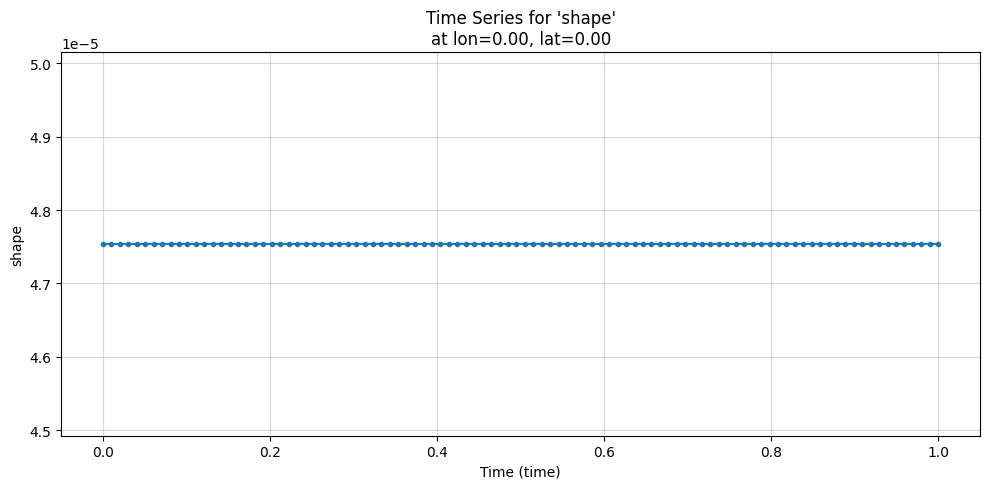

<xarray.Dataset> Size: 3kB
Dimensions:   (lon: 10, lat: 10)
Coordinates:
  * lat       (lat) float64 80B 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * lon       (lon) float64 80B 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
    time      float64 8B 0.0
Data variables:
    location  (lon, lat) float64 800B 0.06799 0.06799 ... 0.06799 0.06799
    scale     (lon, lat) float64 800B 0.04017 0.04017 ... 0.04017 0.04017
    shape     (lon, lat) float64 800B 4.754e-05 4.754e-05 ... 4.754e-05
Attributes:
    aggregation_dimension:  simulation_run
    aggregation_function:   var
    aggregation_kwargs:     {}

In [79]:
plot_time(v,var_name='shape')
v.isel(time=0)

In [62]:
print(true_var)
print(true_bias)
print(true_mse)

[6.36152401e-02 2.19516699e-01 4.90778856e-02 1.50579554e-01
 6.28819172e-05]
[ 1.57593310e+00  5.31954261e-02  2.75503903e-01 -7.96756948e-02
  7.06094410e-04]
[2.54718036e+00 2.22346453e-01 1.24980286e-01 1.56927771e-01
 6.33804865e-05]


In [34]:
print(true_var)
print(true_bias)
print(true_mse)
print(np.sqrt(true_mse))

[1.62337548e-01 1.25098167e-01 1.59751914e-01 2.43330260e-01
 9.35043563e-02 1.14996843e-01 9.49787325e-02 1.52516570e-01
 7.84881053e-05]
[ 0.03429938 -0.00331246 -0.00441218 -0.11059937  0.03822917 -0.03136983
 -0.03048396 -0.07823813  0.00060248]
[1.63513995e-01 1.25109140e-01 1.59771382e-01 2.55562480e-01
 9.49658259e-02 1.15980909e-01 9.59080045e-02 1.58637776e-01
 7.88510858e-05]
[0.40436864 0.3537077  0.39971413 0.50553188 0.30816526 0.3405597
 0.30969018 0.39829358 0.00887981]


In [130]:
scalar_variance = v.mean()
scalar_bias = b.mean()
scalar_mse = mse.mean()

print(f"Overall Mean Variance: {scalar_variance}")
print(f"Overall Mean Bias: {scalar_bias}")
print(f"Overall Mean Squared Error (MSE): {scalar_mse}")

Overall Mean Variance: <xarray.Dataset>
Dimensions:   ()
Data variables:
    location  float64 4.208
    scale     float64 2.611
    shape     float64 0.007257
Overall Mean Bias: <xarray.Dataset>
Dimensions:   ()
Data variables:
    location  float64 0.1031
    scale     float64 -0.2436
    shape     float64 0.0006775
Overall Mean Squared Error (MSE): <xarray.Dataset>
Dimensions:   ()
Data variables:
    location  float64 4.223
    scale     float64 2.673
    shape     float64 0.007263


In [128]:
scalar_variance = v.mean()
scalar_bias = b.mean()
scalar_mse = mse.mean()

print(f"Overall Mean Variance: {scalar_variance}")
print(f"Overall Mean Bias: {scalar_bias}")
print(f"Overall Mean Squared Error (MSE): {scalar_mse}")

Overall Mean Variance: <xarray.Dataset>
Dimensions:   ()
Data variables:
    location  float64 0.07643
    scale     float64 0.04598
    shape     float64 4.948e-05
Overall Mean Bias: <xarray.Dataset>
Dimensions:   ()
Data variables:
    location  float64 0.005225
    scale     float64 -0.003667
    shape     float64 -6.817e-05
Overall Mean Squared Error (MSE): <xarray.Dataset>
Dimensions:   ()
Data variables:
    location  float64 0.07651
    scale     float64 0.04604
    shape     float64 4.948e-05


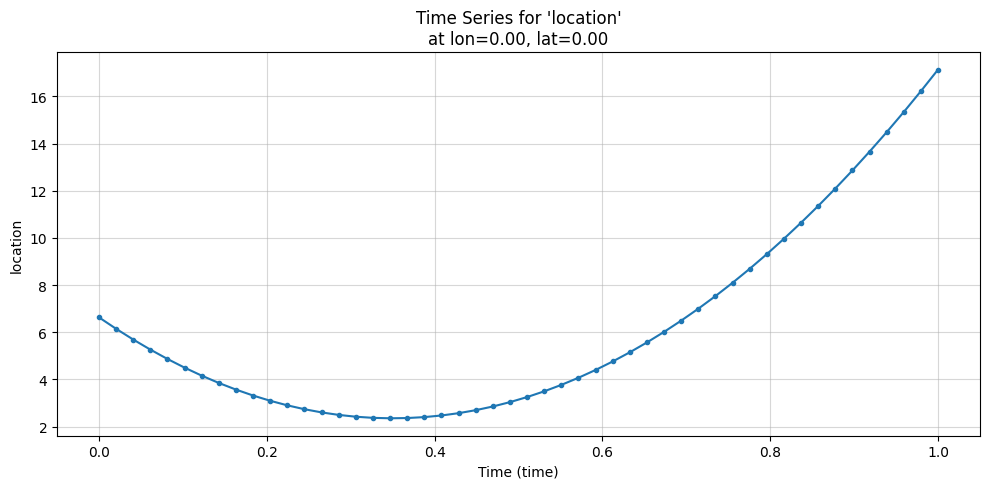

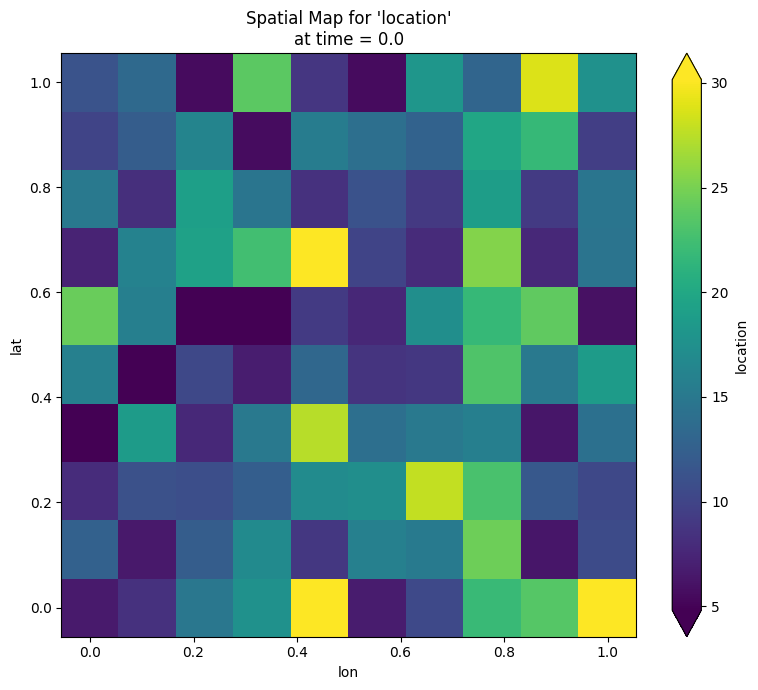

In [116]:
#plot_map(b, var_name="location")
plot_time(v+b**2, var_name="location")
plot_map(v+b**2, var_name="location")

In [9]:
def run_simulation_sweep_agg(
    sim_func_raw: Callable, # e.g., run_simulation_raw (needs adaptation)
    param_sweep_config: Dict[str, List[Any]], # Params to vary
    base_sim_config: Dict[str, Any], # Base config with new structure
    aggregation_func: Callable = np.nanmean,
    show_sweep_progress: bool = True,
    show_inner_progress: bool = False,
    marginal = False
) -> xr.Dataset:
    """
    Runs simulation sweeps, supporting separate trend configs per GEV param.

    Assumes `sim_func_raw` uses a `sim_config` containing a 'trend_config'
    dictionary specifying generator functions and parameters for 'location',
    'scale', and 'shape' independently.

    Args:
        sim_func_raw (Callable): The global simulation function adapted for the
            new config structure. Expected signature:
            `(sim_config, show_progress) -> Tuple[Dict, List]`.
            Note: data_generator_func is now implicitly defined within sim_config.
        param_sweep_config (Dict[str, List[Any]]): Dictionary defining parameters
            within `base_sim_config` to vary and their values. Can target nested
            keys (e.g., within trend_config params).
        base_sim_config (Dict[str, Any]): The base configuration dictionary,
            expected to contain a 'trend_config' key structuring the trend generation.
        aggregation_func (Callable): Aggregation function (e.g., np.nanmean).
        show_sweep_progress (bool): Show progress bar for the sweep loop.
        show_inner_progress (bool): Show progress bar for inner simulation loop.

    Returns:
        xr.Dataset: Aggregated simulation results.
    """
    sweep_param_names = list(param_sweep_config.keys())
    sweep_param_values_lists = list(param_sweep_config.values())
    param_combinations = list(itertools.product(*sweep_param_values_lists))

    aggregated_results_store = {}
    gev_params_order = None
    all_metrics_detected = set()

    print(f"Starting parameter sweep over: {sweep_param_names}")
    # Generator info is now within the config, maybe print target GEV params?
    target_trend_params = list(base_sim_config.get('trend_config', {}).keys())
    print(f"Trend generation configured for: {target_trend_params}")
    print(f"Total combinations: {len(param_combinations)}")

    iterable_combos = param_combinations
    if show_sweep_progress:
        iterable_combos = tqdm(param_combinations, desc="Parameter Sweep")

    for combo in iterable_combos:
        current_sweep_params = dict(zip(sweep_param_names, combo))
        current_run_config = copy.deepcopy(base_sim_config)

        # --- Update config with sweep values ---
        # This needs to handle potential nesting within 'trend_config'
        trend_config = current_run_config.setdefault('trend_config', {})
        for key, value in current_sweep_params.items():
            updated = False
            # Check if key targets a parameter within a specific trend config
            for gev_param_key in ['location', 'scale', 'shape']:
                if gev_param_key in trend_config and trend_config[gev_param_key] and isinstance(trend_config[gev_param_key], dict):
                     param_dict = trend_config[gev_param_key].setdefault('params', {})
                     if key in param_dict:
                          param_dict[key] = value
                          updated = True
                          break # Assume key only exists once at this level
            # If not updated in nested params, update at top level
            if not updated:
                current_run_config[key] = value
        # --- End config update ---

        combo_aggregated_metrics = {}
        try:
            # Call the GLOBAL simulation function (which now internally handles
            # calling the correct generators based on the merged config)
            # Note: data_generator_func is no longer passed explicitly here
            raw_results_dict, current_gev_params = sim_func_raw(
                sim_config=current_run_config,
                show_progress=show_inner_progress,
                marginal = marginal
            )

            # --- Result processing and aggregation (same as before) ---
            if not raw_results_dict or not any(v.size > 0 for v in raw_results_dict.values()):
                 warnings.warn(f"Raw simulation returned no results for combo: {current_sweep_params}. Skipping.")
                 aggregated_results_store[combo] = None
                 continue

            if gev_params_order is None: gev_params_order = current_gev_params
            elif gev_params_order != current_gev_params: warnings.warn("Inconsistent GEV param order!")

            combo_aggregated_metrics = aggregate_simulation_results(
                raw_results_dict=raw_results_dict,
                gev_params_order=gev_params_order,
                aggregation_func=aggregation_func
            )

            if not combo_aggregated_metrics:
                 warnings.warn(f"Aggregation empty for combo: {current_sweep_params}. Skipping.")
                 aggregated_results_store[combo] = None
                 continue

            aggregated_results_store[combo] = combo_aggregated_metrics
            all_metrics_detected.update(combo_aggregated_metrics.keys())

        except Exception as e:
            warnings.warn(f"Error during sim/agg for combo {current_sweep_params}: {e}. Skipping combo.")
            aggregated_results_store[combo] = None

    # --- Process results into xarray Dataset (same as before) ---
    if not aggregated_results_store or all(v is None for v in aggregated_results_store.values()):
        print("No simulation combinations produced valid data.")
        return xr.Dataset()

    if gev_params_order is None:
         gev_params_order = base_sim_config.get('gev_params_order', None)
         if gev_params_order is None:
              print("Error: Could not determine GEV parameter order.")
              return xr.Dataset()
         else: warnings.warn("GEV parameter order determined from base_sim_config fallback.")

    all_metrics = sorted(list(all_metrics_detected))
    coords = {name: values for name, values in param_sweep_config.items()}
    coords['gev_param'] = gev_params_order

    data_vars_np = {}
    output_shape = tuple(len(v) for v in sweep_param_values_lists) + (len(gev_params_order),)
    for metric in all_metrics: data_vars_np[metric] = np.full(output_shape, np.nan)

    sweep_indices_generator = itertools.product(*(range(len(v)) for v in sweep_param_values_lists))
    param_combo_list = list(itertools.product(*sweep_param_values_lists))

    for i, combo_indices in enumerate(sweep_indices_generator):
        combo_tuple = param_combo_list[i]
        aggregated_metrics = aggregated_results_store.get(combo_tuple)
        if aggregated_metrics:
            for metric in all_metrics:
                 metric_array_1d = aggregated_metrics.get(metric)
                 if metric_array_1d is not None and isinstance(metric_array_1d, np.ndarray):
                     if metric_array_1d.shape == (len(gev_params_order),):
                         data_vars_np[metric][combo_indices] = metric_array_1d

    data_vars_xr = {}
    output_dims = sweep_param_names + ['gev_param']
    for metric in all_metrics:
        if metric in data_vars_np:
             data_vars_xr[metric] = xr.DataArray(data_vars_np[metric], coords=coords, dims=output_dims, name=metric)

    results_ds = xr.Dataset(data_vars_xr)
    # Update attributes
    results_ds.attrs['description'] = "Aggregated simulation sweep results (multi-trend config)."
    results_ds.attrs['simulation_function'] = sim_func_raw.__name__
    # Can't easily list all generators now, maybe store trend_config structure?
    results_ds.attrs['trend_config_structure'] = str(base_sim_config.get('trend_config', {}).keys())
    results_ds.attrs['aggregation_function'] = aggregation_func.__name__
    results_ds.attrs['sweep_parameters'] = sweep_param_names
    results_ds.attrs['base_config_used'] = True

    print(f"\nParameter sweep finished ({len(param_combinations)} combinations run).")
    return results_ds

In [ ]:
marginal = False
# Define the new base config structure
base_config_multi_trend = {
    # --- Simulation Control & Basic Params ---
    'num_simulations': 1, 'seed': 21,
    'metrics_to_track': ['bias', 'variance'],
    'gev_params_order': ['location', 'scale', 'shape'],
    'res': 10, 'num_t': 100,
    # --- Base GEV Params ---
    'base_location': 0, # Base value if trend func returns 0 or is None
    'base_scale': 1,
    'base_shape': 0.1,
    # --- Trend Generation Config ---
    'trend_config': {
        'location': {
            'generator_func': generate_complete_trend_st,
            'params': {'intercept_range': (28, 28), 't_coeff_range' : (3,3), 'coeff_x_range' : (5,5),'coeff_y_range' : (-5,-5)}
        },
        'scale': {
        'generator_func': generate_complete_trend_st,
        'params': {'intercept_range': (10, 10), 't_coeff_range' : (1,1), 'coeff_x_range' : (2,2),'coeff_y_range' : (-3,-3)}
        },
    },
    # --- Flattening Config ---
    'endog_var': 'extreme_value', 'include_time_coords': True, 'include_space_coords': not marginal,
    # --- Fitting Config ---
    'fit_method': 'MLE',
    'gev_param_exog_map': {'location': True, 'scale': True, 'shape': False}, # Fit trend only for loc
    'apply_start_noise': False, 'start_params_noise_std': 0.1,
    #'start_params' : [28,10, 10, 5, 0.3]
}

# Define sweep: Vary location trend intercept and resolution
sweep_config_multi = {
    'res': [15]                 
}

print("\n--- Running Parameter Sweep (Multi-Trend Config) ---")
# Assume run_simulation_raw is adapted to handle the new 'trend_config'
# Assume aggregate_simulation_results is defined

# Note: The 'data_generator_func' argument is removed as the functions
# are now specified *inside* the base_sim_config.
sweep_results_multi = run_simulation_sweep_agg(
    sim_func_raw=run_simulation_raw,         # Global sim func (must be adapted)
    param_sweep_config=sweep_config_multi,   # What to vary
    base_sim_config=base_config_multi_trend, # Base config with new structure
    aggregation_func=np.mean,
    show_sweep_progress=False,
    marginal = marginal
)

print("\n--- Final Sweep Results (Multi-Trend) ---")
print(sweep_results_multi)

# Example access
if 'bias' in sweep_results_multi:
    print("\n--- Bias Results (res=8) ---")
    try:
        print(sweep_results_multi['bias'].sel(res=10, method='nearest'))
    except Exception as e:
        print(f"Could not select res=8: {e}")


--- Running Parameter Sweep (Multi-Trend Config) ---
Starting parameter sweep over: ['res']
Trend generation configured for: ['location', 'scale']
Total combinations: 1

Parameter sweep finished (1 combinations run).

--- Final Sweep Results (Multi-Trend) ---
<xarray.Dataset> Size: 148B
Dimensions:    (res: 1, gev_param: 3)
Coordinates:
  * res        (res) int32 4B 15
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (res, gev_param) float64 24B 0.2391 -0.1173 0.001496
    variance   (res, gev_param) float64 24B 3.093 1.967 0.007557
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale'])
    aggregation_function:    mean
    sweep_parameters:        ['res']
    base_config_used:        True

--- Bias Results (res=8) ---
<xarray.DataArray 'bias' (gev_param: 3)> Size: 24B
array([ 0.23909171, -0.1172

In [14]:
sweep_results_multi

<xarray.Dataset> Size: 148B
Dimensions:    (res: 1, gev_param: 3)
Coordinates:
  * res        (res) int32 4B 15
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (res, gev_param) float64 24B 0.1131 -0.1708 -0.00294
    variance   (res, gev_param) float64 24B 0.1131 -0.1708 -0.00294
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale'])
    aggregation_function:    mean
    sweep_parameters:        ['res']
    base_config_used:        True


--- RMSE for Scale Parameter vs. Resolution ---
<xarray.DataArray 'rmse' (res: 1)> Size: 8B
array([3.74103297])
Coordinates:
  * res        (res) int32 4B 15
    gev_param  <U8 32B 'scale'


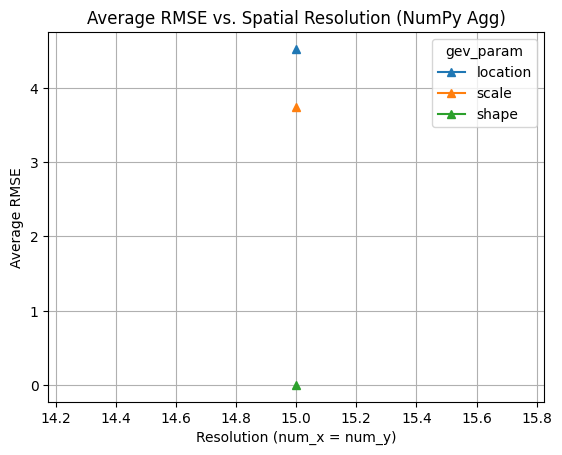

In [64]:
# --- Example: Accessing specific data ---
if 'rmse' in sweep_results_multi and 'res' in sweep_results_multi.coords:
    try:
        print("\n--- RMSE for Scale Parameter vs. Resolution ---")
        print(sweep_results_multi['rmse'].sel(gev_param='scale'))

        # --- Example: Plotting (requires matplotlib) ---
        import matplotlib.pyplot as plt

        # Plot nRMSE vs resolution for each GEV parameter
        nrmse_data = sweep_results_multi['rmse']
        nrmse_data.plot.line(x='res', hue='gev_param', marker='^') # Use different marker
        plt.title('Average RMSE vs. Spatial Resolution (NumPy Agg)')
        plt.xlabel('Resolution (num_x = num_y)')
        plt.ylabel('Average RMSE')
        plt.grid(True)
        plt.show()

    except ImportError:
        print("\nMatplotlib not installed. Skipping plot example.")
    except Exception as plot_e:
        print(f"\nError during plotting: {plot_e}")

In [65]:
sweep_results_multi.sel(res=15)

<xarray.Dataset> Size: 172B
Dimensions:    (gev_param: 3)
Coordinates:
    res        int32 4B 15
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (gev_param) float64 24B 0.01811 0.001366 0.0001356
    rmse       (gev_param) float64 24B 4.524 3.741 0.004125
    sd         (gev_param) float64 24B 4.523 3.74 1.915e-17
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale'])
    aggregation_function:    mean
    sweep_parameters:        ['res']
    base_config_used:        True

In [8]:
import pickle
from pathlib import Path

output_folder = Path("./simulation_output")
# Use a common extension for pickled files, like .pkl or .pickle
file_name = "sim2.pkl"
output_path = output_folder / file_name

# --- Ensure Output Folder Exists ---
output_folder.mkdir(parents=True, exist_ok=True)

# --- Save the xarray Dataset using pickle ---
try:
    # Open the file in binary write mode ('wb')
    with open(output_path, 'wb') as f:
        pickle.dump(sweep_results_multi, f)
    print(f"Successfully saved (pickled) Dataset object to: {output_path}")
except Exception as e:
    print(f"Error saving (pickling) Dataset to {output_path}: {e}")

Error saving (pickling) Dataset to simulation_output\sim2.pkl: name 'sweep_results_multi' is not defined


In [16]:
import pickle
from pathlib import Path
output_folder = Path("./simulation_output")
file_name = "sim4.pkl"
output_path = output_folder / file_name

try:
    # Open the file in binary read mode ('rb')
    with open(output_path, 'rb') as f:
        loaded_ds = pickle.load(f)
    print(f"\nSuccessfully loaded (unpickled) Dataset object from: {output_path}")
    print("\nLoaded Dataset:")
    print(loaded_ds)
    print("\nChecking boolean attribute:")
    print(f"loaded_ds.attrs['base_config_used'] = {loaded_ds.attrs['base_config_used']} (Type: {type(loaded_ds.attrs['base_config_used'])})")
    print("\nChecking list attribute:")
    print(f"loaded_ds.attrs['some_list'] = {loaded_ds.attrs['some_list']} (Type: {type(loaded_ds.attrs['some_list'])})")

except FileNotFoundError:
    print(f"\nError: File not found at {output_path}")
except Exception as e:
    print(f"\nError loading (unpickling) Dataset from {output_path}: {e}")
    loaded_ds


Successfully loaded (unpickled) Dataset object from: simulation_output\sim4.pkl

Loaded Dataset:
<xarray.Dataset> Size: 552B
Dimensions:            (res: 6, gev_param: 3)
Coordinates:
  * res                (res) int32 24B 2 3 5 10 15 20
  * gev_param          (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias               (res, gev_param) float64 144B 0.648 -0.648 ... -0.0004099
    rmse               (res, gev_param) float64 144B 4.843 3.728 ... 0.002604
    variance_of_error  (res, gev_param) float64 144B 16.74 8.599 ... 6.053e-31
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale', 'shape'])
    aggregation_function:    nanmedian
    sweep_parameters:        ['res']
    base_config_used:        True

Checking boolean attribute:
loaded_ds.attrs['base_config_used'] = True (Type: <class 'bool'>)

Checking list attri

In [17]:
output_path = output_folder / file_name

try:
    # Open the file in binary read mode ('rb')
    with open(output_path, 'rb') as f:
        loaded_ds = pickle.load(f)
    print(f"\nSuccessfully loaded (unpickled) Dataset object from: {output_path}")
    print("\nLoaded Dataset:")
    print(loaded_ds)
    print("\nChecking boolean attribute:")
    print(f"loaded_ds.attrs['base_config_used'] = {loaded_ds.attrs['base_config_used']} (Type: {type(loaded_ds.attrs['base_config_used'])})")
    print("\nChecking list attribute:")
    print(f"loaded_ds.attrs['some_list'] = {loaded_ds.attrs['some_list']} (Type: {type(loaded_ds.attrs['some_list'])})")

except FileNotFoundError:
    print(f"\nError: File not found at {output_path}")
except Exception as e:
    print(f"\nError loading (unpickling) Dataset from {output_path}: {e}")
    loaded_ds


Successfully loaded (unpickled) Dataset object from: simulation_output\sim4.pkl

Loaded Dataset:
<xarray.Dataset> Size: 552B
Dimensions:            (res: 6, gev_param: 3)
Coordinates:
  * res                (res) int32 24B 2 3 5 10 15 20
  * gev_param          (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias               (res, gev_param) float64 144B 0.648 -0.648 ... -0.0004099
    rmse               (res, gev_param) float64 144B 4.843 3.728 ... 0.002604
    variance_of_error  (res, gev_param) float64 144B 16.74 8.599 ... 6.053e-31
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale', 'shape'])
    aggregation_function:    nanmedian
    sweep_parameters:        ['res']
    base_config_used:        True

Checking boolean attribute:
loaded_ds.attrs['base_config_used'] = True (Type: <class 'bool'>)

Checking list attri

In [19]:
loaded_ds.sel(res=15)

<xarray.Dataset> Size: 172B
Dimensions:            (gev_param: 3)
Coordinates:
    res                int32 4B 15
  * gev_param          (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias               (gev_param) float64 24B -0.002411 -0.0255 0.0004545
    rmse               (gev_param) float64 24B 0.6351 0.4723 0.003879
    variance_of_error  (gev_param) float64 24B 0.2605 0.152 3.61e-31
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale', 'shape'])
    aggregation_function:    nanmedian
    sweep_parameters:        ['res']
    base_config_used:        True